In [1]:
from functools import partial

import numpy as np
from scipy.integrate import solve_ivp
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('paper', font_scale=1.4)

The wavelength of a Turing pattern is $2\pi/k$ where 
$$ k^2 = \frac{-d_u d_v(f_u - g_v) + (d_u + d_v)\sqrt{-d_u d_v f_v g_u}}{d_u d_v(d_v - d_u)}$$

The linearized substrate depletion model (Miura & Maini, 2004) is
$$ 
\begin{eqnarray*}
\dot u & = & 0.5u + 0.6v - u^3 + 2\tilde\Delta u \\
\dot v & = & -1.9u - 2v + 25\tilde\Delta v 
\end{eqnarray*}$$

In [28]:
fu = 0.5; fv = 0.6; du = 2; gu = -1.9; gv = -2; dv = 25;

k = np.sqrt((-du*dv*(fu - gv) + (du + dv)*np.sqrt(-du*dv*fv*gu)) / (du*dv*(dv - du)))
2*np.pi/k

23.996077217466947

In [29]:
x = np.arange(0, 101, 1)


D = 0.1
d = 0.01

def source(coupling, _, c):
    dcdt = D*coupling(c) - d*c
    dcdt[0] = 0
    return dcdt
    
    
offset = 1

def turing(coupling, _, uv):
#     assert (uv > 0).all()
    u = uv[:101]
    v = uv[101:]

    dudt = 0.5*(u - offset) + 0.6*(v - offset) - (u - offset)**3 + 2*coupling(u)
    dvdt = -1.9*(u - offset) - 2*(v - offset) + 25*coupling(v)
    return np.append(dudt, dvdt)


def test_diffusion_model(coupling):
    """Plot gradient from source and Turing pattern"""
    plt.figure(figsize=(12, 3))

    analytic_gradient = np.exp(-np.sqrt(d/D)*x)
    c_0 = np.append(1, np.zeros(len(x) - 1))
    c = solve_ivp(partial(source, coupling), [0, 1e3], c_0, 'BDF')

    plt.subplot2grid(shape=(1, 4), loc=(0, 0))
    plt.plot(x[:26], analytic_gradient[:26], 'k')
    plt.plot(x[:26], c.y[:, -1][:26], 'ko')
    plt.legend(['Exponential', coupling.description], frameon=False)
    plt.xlabel('Space')
    plt.xlim([-1, 26])
    plt.ylabel('Concentration')
    plt.yticks([])

    uv_0 = offset + np.random.rand(len(x)*2)/100
    uv = solve_ivp(partial(turing, coupling), [0, 1e3], uv_0, 'BDF')

    plt.subplot2grid(shape=(1, 4), loc=(0, 1), colspan=3)
    plt.plot(x, uv.y[:, -1][101:], 'ko')
    plt.xlabel('Space')
    plt.xlim([-1, 101])
    plt.yticks([0, offset], ['', '$u_0$'])

    sns.despine()
    plt.tight_layout()
    plt.savefig(coupling.description.replace(' ', '_').replace("'", '').replace('.', '') + '.png', 
                dpi=300)
    plt.show()

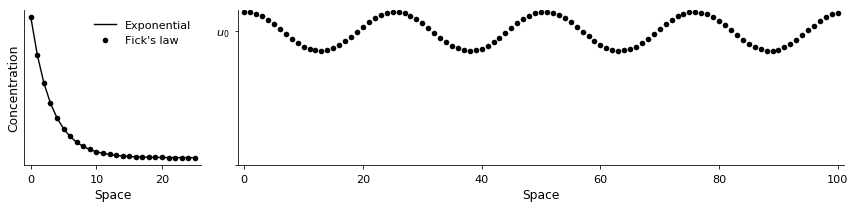

In [30]:
def ficks_law(u):
    """Finite difference scheme for Fick's law"""
    lapl = np.empty(len(u))
    lapl[0] = u[-1] - 2*u[0] + u[1]
    lapl[1:-1] = u[:-2] - 2*u[1:-1] + u[2:]
    lapl[-1] = u[-2] - 2*u[-1] + u[0]
    return lapl


ficks_law.description = "Fick's law"
test_diffusion_model(ficks_law)